To run the code, simply run each cell sequentially. Changing included attributes must be changed in the load_data function.

In [49]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

In [17]:
class PMF(object):
    def __init__(self, num_feat=10, epsilon=1, _lambda=0.1, momentum=0.8, maxepoch=20, num_batches=10, batch_size=1000):
        self.num_feat = num_feat
        self.epsilon = epsilon
        self._lambda = _lambda
        self.momentum = momentum
        self.maxepoch = maxepoch
        self.num_batches = num_batches
        self.batch_size = batch_size
        self.accuracy = []
        self.precision = []
        self.recall = []
        self.f1 = []

        self.w_Item = None
        self.w_User = None

        self.rmse_train = []
        self.rmse_test = []

    def fit(self, train_vec, test_vec, log_file=None):
        if log_file:
            logger = open(log_file, 'w')
            logger.write("epoch,train_error,test_error\n")
        
        self.mean_inv = np.mean(train_vec[:, 2])

        pairs_train = train_vec.shape[0]
        pairs_test = test_vec.shape[0]

        num_user = int(max(np.amax(train_vec[:, 0]), np.amax(test_vec[:, 0]))) + 1
        num_item = int(max(np.amax(train_vec[:, 1]), np.amax(test_vec[:, 1]))) + 1

        if self.w_Item is None:
            self.epoch = 0
            self.w_Item = 0.1 * np.random.randn(num_item, self.num_feat)
            self.w_User = 0.1 * np.random.randn(num_user, self.num_feat)

            self.w_Item_inc = np.zeros((num_item, self.num_feat))
            self.w_User_inc = np.zeros((num_user, self.num_feat))

        for epoch in range(1, self.maxepoch + 1):
            self.epoch = epoch
            shuffled_order = np.arange(train_vec.shape[0])
            np.random.shuffle(shuffled_order)

            for batch in range(self.num_batches):
                test = np.arange(self.batch_size * batch, self.batch_size * (batch + 1))
                batch_idx = np.mod(test, shuffled_order.shape[0])

                batch_UserID = np.array(train_vec[shuffled_order[batch_idx], 0], dtype='int32')
                batch_ItemID = np.array(train_vec[shuffled_order[batch_idx], 1], dtype='int32')

                pred_out = np.sum(np.multiply(self.w_User[batch_UserID, :],
                                              self.w_Item[batch_ItemID, :]),
                                              axis=1)
                
                

                rawErr = pred_out - train_vec[shuffled_order[batch_idx], 2] + self.mean_inv

                Ix_User = 2 * np.multiply(rawErr[:, np.newaxis], self.w_Item[batch_ItemID, :]) \
                       + self._lambda * self.w_User[batch_UserID, :]
                Ix_Item = 2 * np.multiply(rawErr[:, np.newaxis], self.w_User[batch_UserID, :]) \
                       + self._lambda * (self.w_Item[batch_ItemID, :])

                dw_Item = np.zeros((num_item, self.num_feat))
                dw_User = np.zeros((num_user, self.num_feat))

                for i in range(self.batch_size):
                    dw_Item[batch_ItemID[i], :] += Ix_Item[i, :]
                    dw_User[batch_UserID[i], :] += Ix_User[i, :]

                self.w_Item_inc = self.momentum * self.w_Item_inc + self.epsilon * dw_Item / self.batch_size
                self.w_User_inc = self.momentum * self.w_User_inc + self.epsilon * dw_User / self.batch_size
                self.w_Item = self.w_Item - self.w_Item_inc
                self.w_User = self.w_User - self.w_User_inc

                if batch == self.num_batches - 1:
                    pred_out = np.sum(np.multiply(self.w_User[np.array(train_vec[:, 0], dtype='int32'), :],
                                                  self.w_Item[np.array(train_vec[:, 1], dtype='int32'), :]),
                                                  axis=1) 
                    rawErr = pred_out - train_vec[:, 2] + self.mean_inv
                    obj = np.linalg.norm(rawErr) ** 2 \
                          + 0.5 * self._lambda * (np.linalg.norm(self.w_User) ** 2 + np.linalg.norm(self.w_Item) ** 2)

                    self.rmse_train.append(np.sqrt(obj / pairs_train))

                if batch == self.num_batches - 1:
                    pred_out = np.sum(np.multiply(self.w_User[np.array(test_vec[:, 0], dtype='int32'), :],
                                                  self.w_Item[np.array(test_vec[:, 1], dtype='int32'), :]),
                                                  axis=1)
                    rawErr = pred_out - test_vec[:, 2] + self.mean_inv + 0.1

                    adj = pred_out + self.mean_inv

                    print(rawErr)
                    self.rmse_test.append(np.linalg.norm(rawErr) / np.sqrt(pairs_test))

                    rounded = [round(i) for i in adj]
                    self.accuracy.append(accuracy_score(test_vec[:, 2], rounded))
                    self.precision.append(precision_score(test_vec[:, 2], rounded, average='weighted'))
                    self.recall.append(recall_score(test_vec[:, 2], rounded, average='weighted'))
                    self.f1.append(f1_score(test_vec[:, 2], rounded, average='weighted'))
                    
                    if batch == self.num_batches - 1 and log_file:
                        logger.write(f"{self.epoch},{self.rmse_train[-1]},{self.rmse_test[-1]}\n")
            
        if log_file:
            logger.close()

    def predict(self, invID):
        return np.dot(self.w_Item, self.w_User[int(invID), :]) + self.mean_inv

    def set_params(self, parameters):
        if isinstance(parameters, dict):
            self.num_feat = parameters.get("num_feat", 10)
            self.epsilon = parameters.get("epsilon", 1)
            self._lambda = parameters.get("_lambda", 0.1)
            self.momentum = parameters.get("momentum", 0.8)
            self.maxepoch = parameters.get("maxepoch", 20)
            self.num_batches = parameters.get("num_batches", 10)
            self.batch_size = parameters.get("batch_size", 1000)

    def topK(self, test_vec, k=10):
        inv_lst = np.unique(test_vec[:, 0])
        pred = {}
        for inv in inv_lst:
            if pred.get(inv, None) is None:
                pred[inv] = np.argsort(self.predict(inv))[-k:]

        intersection_cnt = {}
        for i in range(test_vec.shape[0]):
            if test_vec[i, 1] in pred[test_vec[i, 0]]:
                intersection_cnt[test_vec[i, 0]] = intersection_cnt.get(test_vec[i, 0], 0) + 1
        invPairs_cnt = np.bincount(np.array(test_vec[:, 0], dtype='int32'))

        precision_acc = 0.0
        recall_acc = 0.0
        for inv in inv_lst:
            precision_acc += intersection_cnt.get(inv, 0) / float(k)
            recall_acc += intersection_cnt.get(inv, 0) / float(invPairs_cnt[int(inv)])

        print(precision_acc, recall_acc)

        return precision_acc / len(inv_lst), recall_acc / len(inv_lst)


In [47]:
def load_data(file_path='ml-100k/u_combined.data'):
    data = []
    with open(file_path, 'r') as f:
        for line in f:
            try:
                userid, movieid, rating, ts, g1, g2, g3, dir, cas1, cas2, cas3, cas4, runtime, language, country, company  = line.split('\t')
                uid = int(userid)
                mid = int(movieid)
                rat = float(rating)
                ts = int(ts)
                g1 = int(g1)
                g2 = int(g2)
                g3 = int(g3)
                dir = int(dir)
                cas1 = int(cas1)
                cas2 = int(cas2)
                cas3 = int(cas3)
                cas4 = int(cas4)
                runtime = int(runtime)
                language = int(language)
                country = int(country)
                company = int(company)
                data.append([uid, mid, rat, g1, g2, g3, dir, cas1, cas2, cas3, cas4, country, company, runtime, language])
            except:
                continue
    
    return np.array(data)

In [48]:
pmf = PMF()
pmf.set_params({"num_feat": 10, "epsilon": 1, "_lambda": 0.1, "momentum": 0.8, "maxepoch": 100, "num_batches": 100,
                "batch_size": 1000})

ratings = load_data()
# train = load_data(file_path='ml-100k/u5.base')
# test = load_data(file_path='ml-100k/u5.test')
train, test = train_test_split(ratings, test_size=0.2)
pmf.fit(train, test, log_file='log.csv')

print(min(pmf.rmse_test))
print(max(pmf.accuracy))
print(max(pmf.precision))
print(max(pmf.recall))
print(max(pmf.f1))

[-0.35586801  0.62789669  0.6140828  ... -0.33708209 -1.39676985
 -0.39815275]


c:\Users\Erik Ren\anaconda3\envs\cs269\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[-0.34864543  0.62948917  0.61521438 ... -0.34561027 -1.39844034
 -0.39218173]


c:\Users\Erik Ren\anaconda3\envs\cs269\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[-0.34164611  0.63051951  0.61897765 ... -0.35853203 -1.39674694
 -0.38732373]


c:\Users\Erik Ren\anaconda3\envs\cs269\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[-0.33617037  0.63357314  0.63680556 ... -0.38281663 -1.3744222
 -0.38472547]


c:\Users\Erik Ren\anaconda3\envs\cs269\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[-0.30180934  0.63328777  0.6913115  ... -0.44210797 -1.29866714
 -0.38331418]


c:\Users\Erik Ren\anaconda3\envs\cs269\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[-0.25571568  0.63143803  0.85493975 ... -0.56695164 -1.19224039
 -0.39889414]


c:\Users\Erik Ren\anaconda3\envs\cs269\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[-0.19824773  0.62356753  0.96867243 ... -0.70562406 -1.09615549
 -0.4312485 ]


c:\Users\Erik Ren\anaconda3\envs\cs269\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[-0.10195825  0.62527519  1.01586935 ... -0.79478106 -1.00857351
 -0.47983398]
[-0.03752842  0.61152492  1.06144585 ... -0.80708162 -0.95610517
 -0.55514776]
[ 0.0685645   0.59221124  1.09913793 ... -0.81861914 -1.02528173
 -0.63224179]
[ 0.12583521  0.58015506  1.10185454 ... -0.82409078 -0.95619062
 -0.6818083 ]


c:\Users\Erik Ren\anaconda3\envs\cs269\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[ 0.26139015  0.5798585   1.11162069 ... -0.83661204 -0.95977013
 -0.74492405]


c:\Users\Erik Ren\anaconda3\envs\cs269\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[ 0.27483545  0.54329034  1.12839711 ... -0.84442493 -1.01333108
 -0.81227404]


c:\Users\Erik Ren\anaconda3\envs\cs269\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[ 0.36685248  0.52082005  1.16433227 ... -0.81554143 -1.01925688
 -0.86702884]


c:\Users\Erik Ren\anaconda3\envs\cs269\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[ 0.39821799  0.51725684  1.18584582 ... -0.81627853 -0.97790914
 -0.92028334]


c:\Users\Erik Ren\anaconda3\envs\cs269\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[ 0.43863831  0.5138343   1.18854985 ... -0.80518916 -0.9294839
 -0.94931921]


c:\Users\Erik Ren\anaconda3\envs\cs269\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[ 0.45810826  0.5090852   1.20728204 ... -0.83049886 -0.98923285
 -0.98470931]


c:\Users\Erik Ren\anaconda3\envs\cs269\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[ 0.4821591   0.46763707  1.19888213 ... -0.81772665 -1.04626758
 -1.02621562]


c:\Users\Erik Ren\anaconda3\envs\cs269\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[ 0.40706633  0.45665927  1.18885622 ... -0.77363892 -1.03889615
 -1.09538649]


c:\Users\Erik Ren\anaconda3\envs\cs269\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[ 0.46287422  0.45037613  1.18613056 ... -0.74660156 -1.04121276
 -1.12571359]


c:\Users\Erik Ren\anaconda3\envs\cs269\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[ 0.47711136  0.45624981  1.17791412 ... -0.75014877 -1.06459725
 -1.15327896]


c:\Users\Erik Ren\anaconda3\envs\cs269\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[ 0.48164002  0.45875183  1.12513037 ... -0.75552712 -1.08680063
 -1.17188226]


c:\Users\Erik Ren\anaconda3\envs\cs269\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[ 0.47934336  0.45275545  1.147814   ... -0.75441195 -1.08149734
 -1.18415767]


c:\Users\Erik Ren\anaconda3\envs\cs269\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[ 0.49539731  0.46770962  1.18266079 ... -0.74926582 -1.12880732
 -1.21587721]


c:\Users\Erik Ren\anaconda3\envs\cs269\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[ 0.48520036  0.45380673  1.1715051  ... -0.73744246 -1.1087088
 -1.2554667 ]


c:\Users\Erik Ren\anaconda3\envs\cs269\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[ 0.50395874  0.4563316   1.14824048 ... -0.71297651 -1.15735927
 -1.28106409]


c:\Users\Erik Ren\anaconda3\envs\cs269\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[ 0.48430098  0.46273742  1.15755477 ... -0.72683298 -1.11791316
 -1.29839692]


c:\Users\Erik Ren\anaconda3\envs\cs269\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[ 0.52045973  0.46498129  1.15876239 ... -0.74764003 -1.15254193
 -1.33577769]


c:\Users\Erik Ren\anaconda3\envs\cs269\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[ 0.48837445  0.46563596  1.15495196 ... -0.72049125 -1.14315089
 -1.34506707]


c:\Users\Erik Ren\anaconda3\envs\cs269\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[ 0.47071991  0.47140187  1.13528005 ... -0.73846691 -1.15670821
 -1.38011575]


c:\Users\Erik Ren\anaconda3\envs\cs269\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[ 0.45435033  0.47329924  1.12933164 ... -0.71314051 -1.15509551
 -1.38778782]


c:\Users\Erik Ren\anaconda3\envs\cs269\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[ 0.47375063  0.48679991  1.13820991 ... -0.67214016 -1.22373297
 -1.42288144]


c:\Users\Erik Ren\anaconda3\envs\cs269\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[ 0.43551658  0.49374996  1.12032935 ... -0.72407856 -1.18904597
 -1.42611423]


c:\Users\Erik Ren\anaconda3\envs\cs269\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[ 0.42181567  0.49211088  1.15783886 ... -0.73150717 -1.18540925
 -1.45564299]


c:\Users\Erik Ren\anaconda3\envs\cs269\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[ 0.42699912  0.46330499  1.18977216 ... -0.75171885 -1.20944804
 -1.50575201]


c:\Users\Erik Ren\anaconda3\envs\cs269\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[ 0.45588605  0.46776616  1.11688617 ... -0.72343906 -1.18085611
 -1.51200607]


c:\Users\Erik Ren\anaconda3\envs\cs269\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[ 0.42729634  0.4597302   1.14814956 ... -0.69696137 -1.14632188
 -1.54069844]


c:\Users\Erik Ren\anaconda3\envs\cs269\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[ 0.43218849  0.45094316  1.17647172 ... -0.68463557 -1.17170388
 -1.56704287]


c:\Users\Erik Ren\anaconda3\envs\cs269\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[ 0.39743993  0.46095014  1.12063768 ... -0.68949409 -1.15292553
 -1.58390828]


c:\Users\Erik Ren\anaconda3\envs\cs269\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[ 0.32974633  0.46343897  1.07734599 ... -0.69885346 -1.14054964
 -1.62455808]


c:\Users\Erik Ren\anaconda3\envs\cs269\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[ 0.40083673  0.45209324  1.08200489 ... -0.70583526 -1.18845415
 -1.61536081]


c:\Users\Erik Ren\anaconda3\envs\cs269\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[ 0.3258432   0.45729468  1.07030807 ... -0.70807692 -1.21848408
 -1.6122265 ]


c:\Users\Erik Ren\anaconda3\envs\cs269\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[ 0.32954955  0.44343405  1.08170954 ... -0.72088885 -1.23106125
 -1.6356344 ]


c:\Users\Erik Ren\anaconda3\envs\cs269\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[ 0.35771852  0.43433759  1.05671973 ... -0.7622711  -1.20181277
 -1.66661855]


c:\Users\Erik Ren\anaconda3\envs\cs269\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[ 0.34444102  0.46687635  1.05323448 ... -0.75519437 -1.18588883
 -1.65788556]


c:\Users\Erik Ren\anaconda3\envs\cs269\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[ 0.33672194  0.4667954   1.06129196 ... -0.72495825 -1.17863194
 -1.68270014]


c:\Users\Erik Ren\anaconda3\envs\cs269\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[ 0.34830937  0.47192873  1.09379631 ... -0.71368756 -1.16877708
 -1.69064648]


c:\Users\Erik Ren\anaconda3\envs\cs269\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[ 0.34331654  0.45617157  1.11258685 ... -0.73361368 -1.15263777
 -1.72388061]


c:\Users\Erik Ren\anaconda3\envs\cs269\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[ 0.36009843  0.46258647  1.09445429 ... -0.76232494 -1.1982513
 -1.70833905]


c:\Users\Erik Ren\anaconda3\envs\cs269\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[ 0.31084096  0.45958139  1.09991197 ... -0.75804908 -1.18915412
 -1.75381189]


c:\Users\Erik Ren\anaconda3\envs\cs269\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[ 0.35452558  0.44396644  1.0746041  ... -0.79369424 -1.17233426
 -1.73121196]


c:\Users\Erik Ren\anaconda3\envs\cs269\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[ 0.37397529  0.45907534  1.09588413 ... -0.82581251 -1.16449247
 -1.74933383]


c:\Users\Erik Ren\anaconda3\envs\cs269\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[ 0.36738122  0.45141846  1.08252298 ... -0.77750053 -1.15859875
 -1.76688053]


c:\Users\Erik Ren\anaconda3\envs\cs269\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[ 0.33949053  0.47517971  1.09332724 ... -0.73087554 -1.14978619
 -1.7850419 ]


c:\Users\Erik Ren\anaconda3\envs\cs269\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[ 0.35288637  0.44996549  1.10634298 ... -0.74235524 -1.13297096
 -1.80879684]


c:\Users\Erik Ren\anaconda3\envs\cs269\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[ 0.36147865  0.4165308   1.09994638 ... -0.72673841 -1.15037316
 -1.8023654 ]


c:\Users\Erik Ren\anaconda3\envs\cs269\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[ 0.39983899  0.4518742   1.08420777 ... -0.75078494 -1.1533183
 -1.83317468]


c:\Users\Erik Ren\anaconda3\envs\cs269\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[ 0.38139254  0.45098085  1.05456617 ... -0.77618333 -1.14553228
 -1.84038785]


c:\Users\Erik Ren\anaconda3\envs\cs269\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[ 0.37419915  0.41832616  1.04561001 ... -0.74373076 -1.12146955
 -1.84304722]


c:\Users\Erik Ren\anaconda3\envs\cs269\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[ 0.39398656  0.4231661   1.045388   ... -0.76088652 -1.15770321
 -1.87159079]


c:\Users\Erik Ren\anaconda3\envs\cs269\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[ 0.40772824  0.43612701  1.03219498 ... -0.75720921 -1.15624595
 -1.86998195]


c:\Users\Erik Ren\anaconda3\envs\cs269\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[ 0.404138    0.48449889  1.02027388 ... -0.78919448 -1.14452849
 -1.92038435]


c:\Users\Erik Ren\anaconda3\envs\cs269\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[ 0.35021779  0.43053418  1.03792699 ... -0.78500234 -1.12090395
 -1.91607759]


c:\Users\Erik Ren\anaconda3\envs\cs269\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[ 0.34319629  0.44898141  1.02856212 ... -0.75665518 -1.07306685
 -1.88268267]


c:\Users\Erik Ren\anaconda3\envs\cs269\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[ 0.34899614  0.45002563  1.04994708 ... -0.76693389 -1.09213885
 -1.92331729]


c:\Users\Erik Ren\anaconda3\envs\cs269\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[ 0.38472641  0.4196804   1.02721436 ... -0.77341015 -1.11218137
 -1.93652727]


c:\Users\Erik Ren\anaconda3\envs\cs269\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[ 0.3868256   0.40462541  1.05127626 ... -0.76068392 -1.13426886
 -1.91931269]


c:\Users\Erik Ren\anaconda3\envs\cs269\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[ 0.3609874   0.42220986  1.04042774 ... -0.76757486 -1.13522077
 -1.90306299]


c:\Users\Erik Ren\anaconda3\envs\cs269\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[ 0.29827179  0.38604939  1.05423584 ... -0.76657728 -1.06298096
 -1.9392407 ]


c:\Users\Erik Ren\anaconda3\envs\cs269\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[ 0.32848667  0.36589004  1.05264101 ... -0.73499442 -1.10708698
 -1.9413524 ]


c:\Users\Erik Ren\anaconda3\envs\cs269\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[ 0.33335306  0.38514486  1.05426004 ... -0.74738147 -1.11741494
 -1.94583787]


c:\Users\Erik Ren\anaconda3\envs\cs269\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[ 0.30007457  0.39769598  1.0237859  ... -0.78832529 -1.0994518
 -1.97261986]


c:\Users\Erik Ren\anaconda3\envs\cs269\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[ 0.31737283  0.3876184   1.00756589 ... -0.8128249  -1.12046546
 -1.95434263]


c:\Users\Erik Ren\anaconda3\envs\cs269\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[ 0.28553524  0.35443863  1.05035086 ... -0.8316998  -1.1253867
 -1.99168584]


c:\Users\Erik Ren\anaconda3\envs\cs269\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[ 0.28791186  0.35319893  1.04905563 ... -0.83266838 -1.11839762
 -1.9631508 ]


c:\Users\Erik Ren\anaconda3\envs\cs269\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[ 0.24710172  0.33406178  1.06106128 ... -0.79117968 -1.11327199
 -1.98054059]


c:\Users\Erik Ren\anaconda3\envs\cs269\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[ 0.25926768  0.35693967  1.06264258 ... -0.74247687 -1.15360903
 -2.04037247]


c:\Users\Erik Ren\anaconda3\envs\cs269\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[ 0.28610324  0.36252624  1.0689217  ... -0.75126346 -1.14527316
 -2.00738084]


c:\Users\Erik Ren\anaconda3\envs\cs269\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[ 0.28885347  0.37548173  1.04920164 ... -0.80008316 -1.12890142
 -2.00681799]


c:\Users\Erik Ren\anaconda3\envs\cs269\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[ 0.25566467  0.38183851  1.03620673 ... -0.79218622 -1.05926298
 -2.01094406]


c:\Users\Erik Ren\anaconda3\envs\cs269\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[ 0.28191739  0.37679741  0.99803398 ... -0.83372033 -1.02609043
 -2.0063676 ]


c:\Users\Erik Ren\anaconda3\envs\cs269\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[ 0.26949854  0.37531176  1.0523856  ... -0.81164379 -1.06388278
 -2.02398168]


c:\Users\Erik Ren\anaconda3\envs\cs269\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[ 0.29949926  0.342336    1.02770039 ... -0.81695793 -1.10146125
 -2.01815752]


c:\Users\Erik Ren\anaconda3\envs\cs269\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[ 0.24707493  0.32995803  1.02337645 ... -0.83091918 -1.0932267
 -1.9725291 ]


c:\Users\Erik Ren\anaconda3\envs\cs269\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[ 0.28101379  0.3205188   1.00553135 ... -0.89120113 -1.07940587
 -2.02179343]


c:\Users\Erik Ren\anaconda3\envs\cs269\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[ 0.29272685  0.31131111  0.99416996 ... -0.8858425  -1.08661441
 -2.04844727]


c:\Users\Erik Ren\anaconda3\envs\cs269\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[ 0.30850305  0.32743979  0.98571523 ... -0.8018237  -1.0484577
 -2.03092329]


c:\Users\Erik Ren\anaconda3\envs\cs269\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[ 0.26702613  0.30384315  1.0087843  ... -0.77935047 -1.08380713
 -2.02616229]


c:\Users\Erik Ren\anaconda3\envs\cs269\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[ 0.3045332   0.29520993  1.04160425 ... -0.78193613 -1.05344511
 -2.01616385]


c:\Users\Erik Ren\anaconda3\envs\cs269\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[ 0.31840841  0.28645921  1.03857349 ... -0.7837964  -1.05883196
 -2.02394306]


c:\Users\Erik Ren\anaconda3\envs\cs269\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[ 0.3424202   0.29259568  1.03114899 ... -0.82335067 -1.07269556
 -2.02400516]


c:\Users\Erik Ren\anaconda3\envs\cs269\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[ 0.331608    0.28209324  1.00047435 ... -0.87512182 -1.10196878
 -2.00990761]


c:\Users\Erik Ren\anaconda3\envs\cs269\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[ 0.35555472  0.30635175  0.99461915 ... -0.87650321 -1.10754264
 -2.03177987]


c:\Users\Erik Ren\anaconda3\envs\cs269\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[ 0.31980331  0.29350319  0.97298774 ... -0.85323306 -1.09130477
 -2.05591605]


c:\Users\Erik Ren\anaconda3\envs\cs269\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[ 0.30965777  0.31447337  0.97457385 ... -0.84994815 -1.10909366
 -2.06454747]


c:\Users\Erik Ren\anaconda3\envs\cs269\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[ 0.2904306   0.33613658  0.98454823 ... -0.82636565 -1.0973251
 -2.09144282]


c:\Users\Erik Ren\anaconda3\envs\cs269\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[ 0.27755077  0.33698168  0.9809116  ... -0.82071499 -1.05603992
 -2.06781462]


c:\Users\Erik Ren\anaconda3\envs\cs269\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[ 0.28271514  0.35176871  0.94279883 ... -0.85812944 -1.08112391
 -2.04922075]


c:\Users\Erik Ren\anaconda3\envs\cs269\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[ 0.29263971  0.32661481  0.98142975 ... -0.83533371 -1.0989073
 -2.07998691]


c:\Users\Erik Ren\anaconda3\envs\cs269\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[ 0.28995823  0.32881378  0.97310602 ... -0.82743171 -1.16169042
 -2.07133657]
0.9477925217389916
0.4227904167505537
0.4956188178792361
0.4227904167505537
0.39519198944357875


c:\Users\Erik Ren\anaconda3\envs\cs269\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


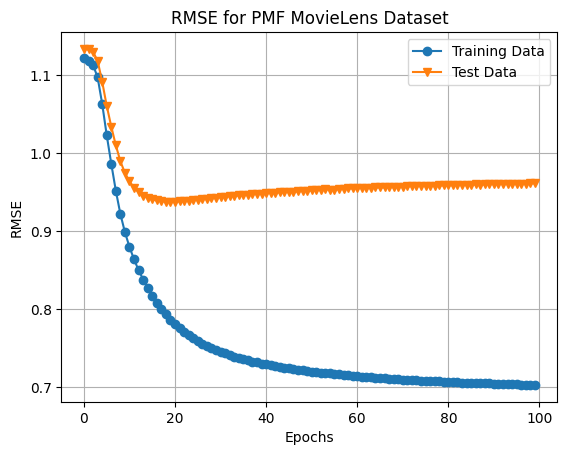

29.000000000000078 12.788523212176804
precision_acc,recall_acc:(0.030851063829787317, 0.013604811927847663)


In [8]:
plt.plot(range(pmf.maxepoch), pmf.rmse_train, marker='o', label='Training Data')
plt.plot(range(pmf.maxepoch), pmf.rmse_test, marker='v', label='Test Data')
plt.title('RMSE for PMF MovieLens Dataset')
plt.xlabel('Epochs')
plt.ylabel('RMSE')
plt.legend()
plt.grid()
plt.show()
print(f"precision_acc,recall_acc:{pmf.topK(test)}")